<a href="https://colab.research.google.com/github/behzadhaki/CMC_SMC/blob/main/Lab2_Generating_Drums_with_a_pre_trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 - In this lab, we will learn how to use a trained model to generate content.
-----

### Clone the repo and install all necessary packages

In [ ]:
!git clone https://github.com/behzadhaki/CMC_SMC
# !git pull --update
%cd CMC_SMC/Lab2

Cloning into 'CMC_SMC'...
remote: Enumerating objects: 1051, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 1051 (delta 90), reused 250 (delta 79), pack-reused 786
Receiving objects: 100% (1051/1051), 362.77 MiB | 26.37 MiB/s, done.
Resolving deltas: 100% (296/296), done.
Updating files: 100% (108/108), done.
/content/CMC_SMC/Lab2/CMC_SMC/Lab2/CMC_SMC/Lab2


### Install Required Packages

In [ ]:
!apt install fluidsynth
!pip install note-seq
!pip install pyfluidsynth

In [ ]:
import torch
import os
from helpers.VAE.modelLoader import load_variational_mgt_model
from bokeh.io import output_notebook
from bokeh.plotting import show
import IPython.display as ipd
import sys

from hvo_sequence.hvo_seq import HVO_Sequence
from data.src.dataLoaders import load_gmd_hvo_sequences

import numpy as np
import pandas as pd

import uuid

output_notebook()

### Utility Methods that we will keep using in this lab

In [ ]:
## Utility Methods
def fix_dimensions(hvo_tensor):
  """Adjusts the length of the hvo sequence to 32 time steps.
  Adjustment by truncation or padding with zeros
  Works for tensor of shape (T, N*3) and also (1, T, N*3) 
  where T is time steps and N is the number of voices
  """
  if len(hvo_tensor.shape)==2:
    number_of_steps = hvo_tensor.shape[0]
    if number_of_steps > 32:
      hvo_tensor = hvo_tensor[:32, :]
    elif number_of_steps < 32:
        hvo_tensor = torch.concatenate(
            (hvo_tensor, torch.zeros((32 - number_of_steps, hvo_tensor.shape[-1]))), axis=0)
  else:
    number_of_steps = hvo_tensor.shape[1]
    if number_of_steps > 32:
        hvo_tensor = hvo_tensor[:, :32, :]
    elif number_of_steps < 32:
        hvo_tensor = torch.concatenate(
            (hvo_tensor, torch.zeros((1, 32 - number_of_steps, hvo_tensor.shape[-1]))), axis=1)
  return hvo_tensor

def get_flattened_version(sample_hvo_seq):
  """ Returns a new hvo_sequence class that hold the flattened version 
  --> Useful for plotting and generationg audios 
  """
  groove_temp = sample_hvo_seq.copy_zero()
  groove_temp.hvo = fix_dimensions(sample_hvo_seq.flatten_voices(reduce_dim=False))
  return groove_temp


def plot_and_synthesize(hvo_seq_sample):
  """ Plots the piano roll of the sequence stored in the hvo_sequence object
  and also returns the synthesized pattern
  """
  hvo_seq_sample.piano_roll(show_figure=True)
  audio = hvo_seq_sample.synthesize(
      sf_path="hvo_sequence/soundfonts/TamaRockSTAR.sf2")
  return audio

def encode_into_latent_z(model_, in_groove):
  """ returns Z corresponding to a provided groove of shape (1, 32, 3)
  """
  # Generation using an Input Groove
  # Step 1. Get the mean and var of the latent encoding
  mu, logvar = model_.encode_to_mu_logvar(in_groove)
  
  # Step 2. Sample a latent vector (z) from latent distribution
  latent_z = model_.reparametrize(mu, logvar)
    
  return latent_z

def generate_from_groove(model_, in_groove, sampling_thresh=0.4):
  """ returns a full drum pattern based on the provided input groove
  """
  latent_z = encode_into_latent_z(model_, in_groove)

  # Step 3. Generate using the latent encoding 
  return model.sample(
      latent_z=latent_z, 
      voice_thresholds=[sampling_thresh]*9,
      voice_max_count_allowed=[32]*9,
      return_concatenated=True,
      sampling_mode=0)


def decode_z_into_drums(model_, latent_z, sampling_thresh=0.5):
  """ returns a full drum pattern based on a provided latent encoding Z
  """
  return model_.sample(latent_z=torch.tensor(latent_z, dtype=torch.float32), 
                   voice_thresholds=[sampling_thresh]*9,
                   voice_max_count_allowed=[32]*9,
                   return_concatenated=True,
                   sampling_mode=0)


def save_to_midi(hvo_seq_pattern, filename=None):
  """ saves the score in a hvo_seq_pattern obj as midi
  """
  if filename is None:
    filename = str(uuid.uuid4())
  hvo_seq_pattern.save_hvo_to_midi(f"{filename}.mid")
  print(f"saved to {filename}.mid")

-----

# Loading And Inspecting the Ground Truth Data:
### Groove Midi Dataset: Test Subset

In [ ]:
# Loads all patterns in the test set as a custom class (called HVO_Sequence)
# HVO_Sequence objects contain the score (accessible using .hvo field)
# and also allow for easy inspection/plotting/synthesizing the scores using
# built in functionalities
# Moreover, metadata of a sample (if any) are also available (using .metadata)
# field
test_set = load_gmd_hvo_sequences(
    dataset_setting_json_path = "data/dataset_json_settings/4_4_Beats_gmd.json", 
    subset_tag = "test", 
    force_regenerate=False)

### Visualize and Synthesize Samples

In [ ]:
# grab a sample
ix = 1533 # np.random.randint(len(test_set))
print(ix) #358
gt_sample = test_set[ix]
print(gt_sample.metadata)


# plot and play
audio_gt = plot_and_synthesize(gt_sample)
ipd.Audio(audio_gt, rate=44100, autoplay=False) 

1533
{'Source': 'Groove MIDI Dataset', 'drummer': 'drummer8', 'session': 'session1', 'loop_id': 'drummer8/session1/19:010', 'master_id': 'drummer8/session1/19', 'style_primary': 'funk', 'style_secondary': 'None', 'bpm': '108', 'beat_type': 'beat', 'time_signature': '4-4', 'full_midi_filename': 'drummer8/session1/19_funk_108_beat_4-4.mid', 'full_audio_filename': 'drummer8/session1/19_funk_108_beat_4-4.wav'}


### Extract the Monotonic Groove of the Drum Pattern by flattening all voices into a single voice


In [ ]:
groove_hvo_seq = get_flattened_version(gt_sample)

# plot and play
audio_groove = plot_and_synthesize(groove_hvo_seq)
ipd.Audio(audio_groove, rate=44100, autoplay=False) 

# 2. Generating Drums from an Input Groove

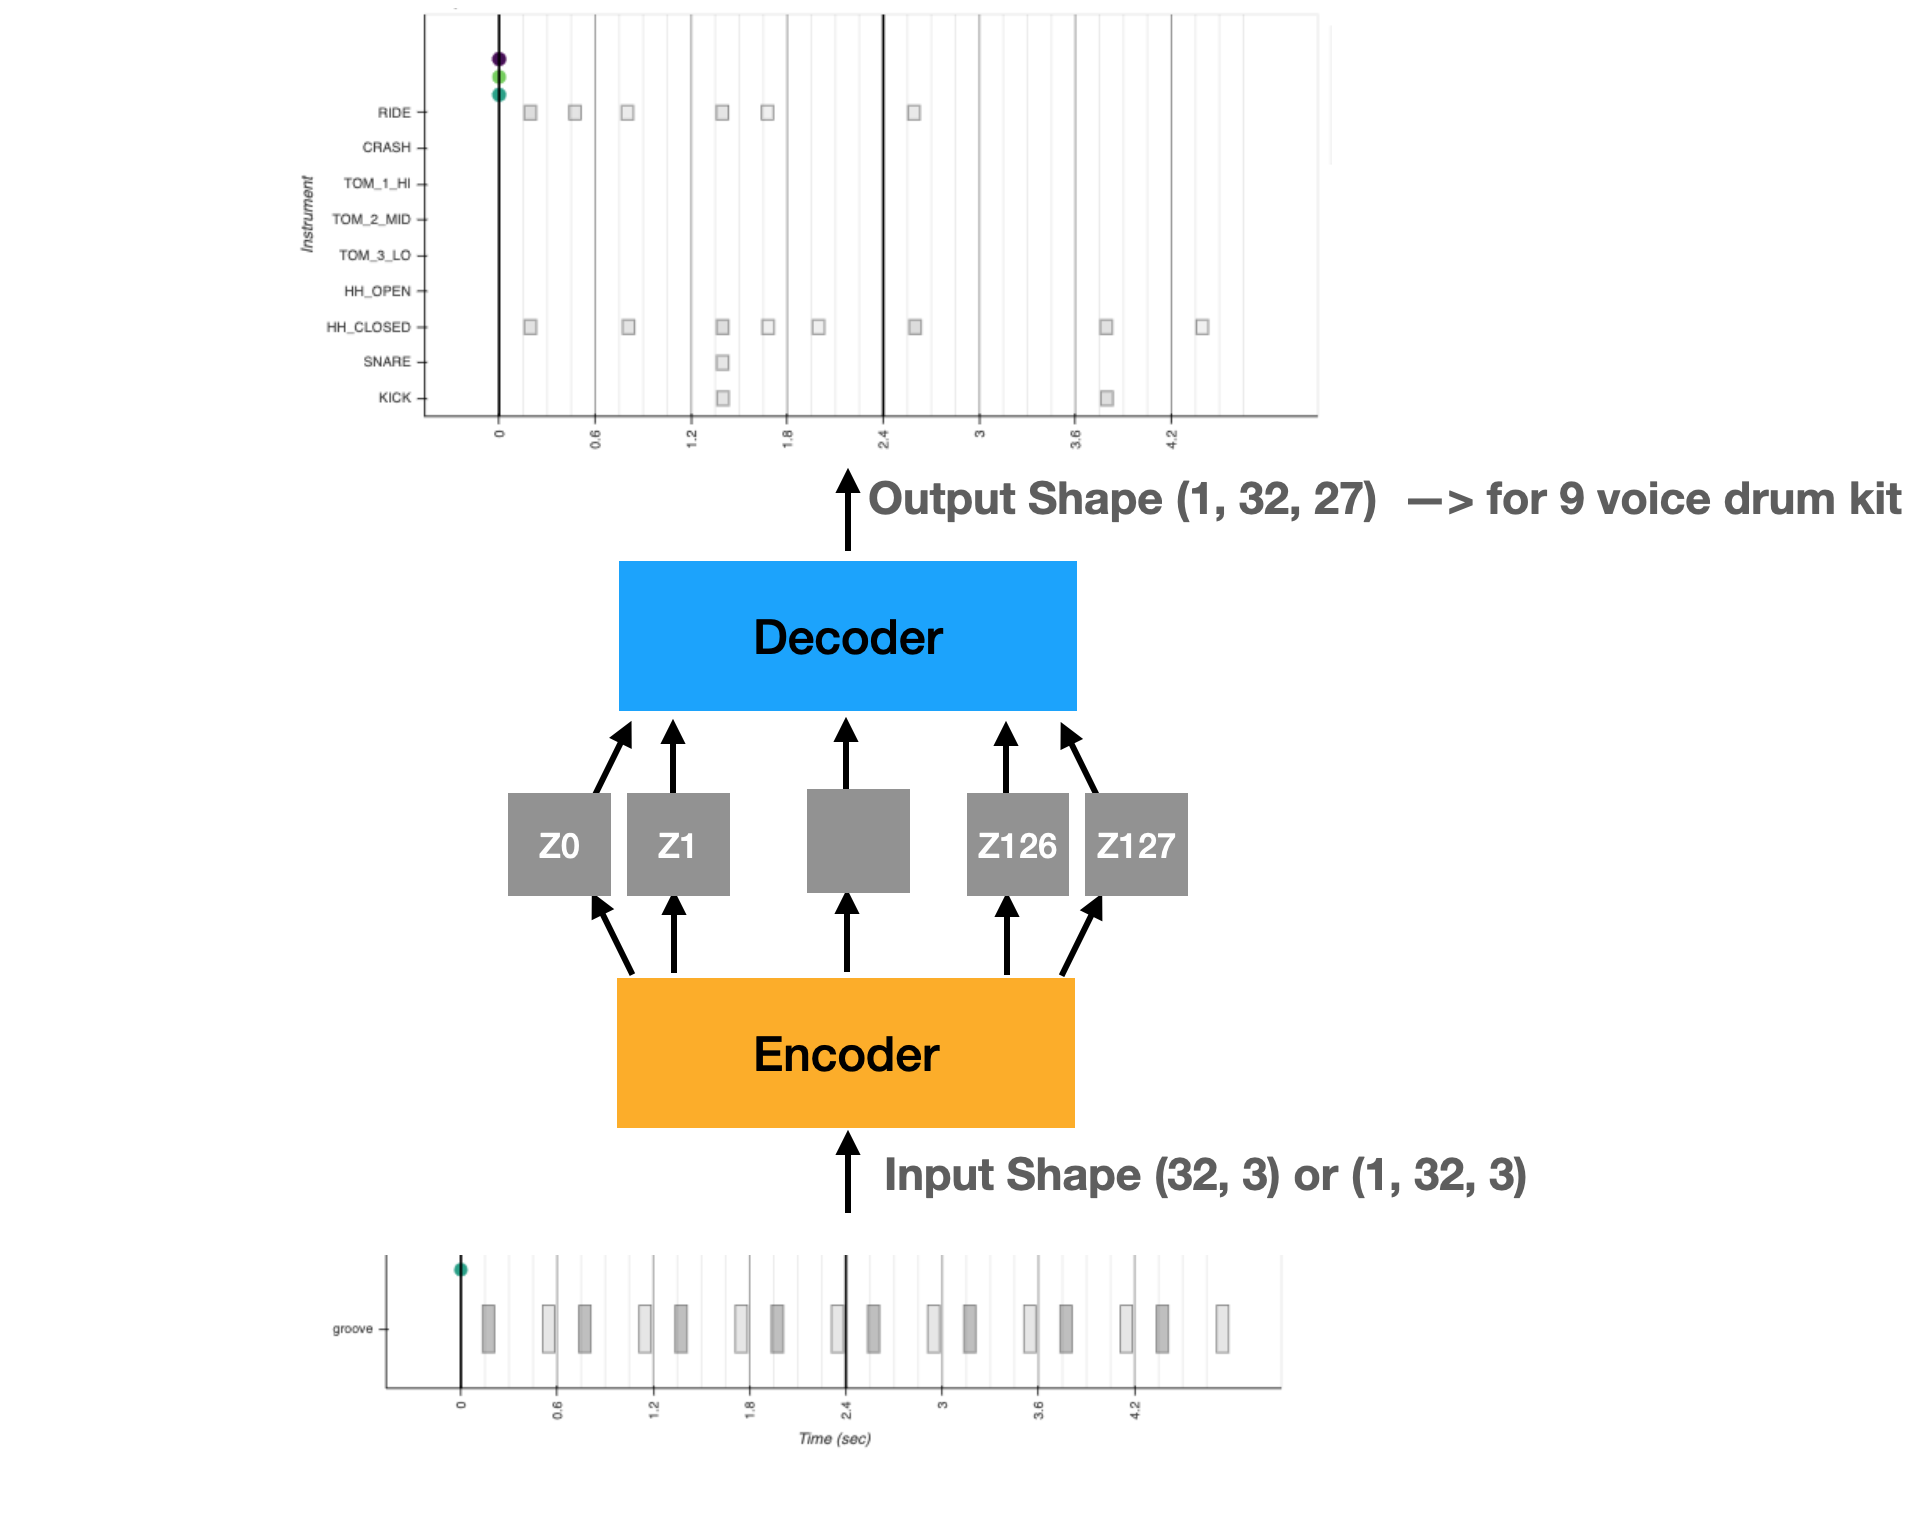

#### Load the model




In [ ]:
model = load_variational_mgt_model("100.pth")

INFO:helpers/VAE/modelLoader.py:Model was loaded to cpu!!!


Offset activation is sigmoid, bias is initialized to 0.5


#### Generate a pattern using the groove extracted from the Ground Truth data



In [ ]:
# Create the groove
groove = fix_dimensions(torch.tensor(
    [gt_sample.flatten_voices(reduce_dim=True)], 
    dtype=torch.float32))
print(f"The shape of the groove tensor is: {groove.shape}")
  
  
generated = generate_from_groove(model, groove)

The shape of the groove tensor is: torch.Size([1, 32, 3])


Visualize Groove / Generation / and Ground Truth

In [ ]:
# Create an instance of hvo_sequence class to visualize
generation_temp = gt_sample.copy_zero()
generation_temp.hvo = generated.detach().cpu().numpy()[0]
groove_temp = gt_sample.copy_zero()
groove_temp.hvo = gt_sample.flatten_voices(reduce_dim=False)


# Add all scores to each other for visualization
concatenetade_scores = gt_sample + groove_temp + generation_temp  

# plot and play
audios = plot_and_synthesize(concatenetade_scores)

print("Ground Truth")
ipd.Audio(audios, rate=44100, autoplay=False) 

Ground Truth


# 3. Generating Patterns without an Input Groove


Here we will ignore the encoder section and generate a random drum pattern by randomly setting latent Z values

These random values can be completely random, or as done below, randomly selected based on distribution of latent z values obtained from real data.


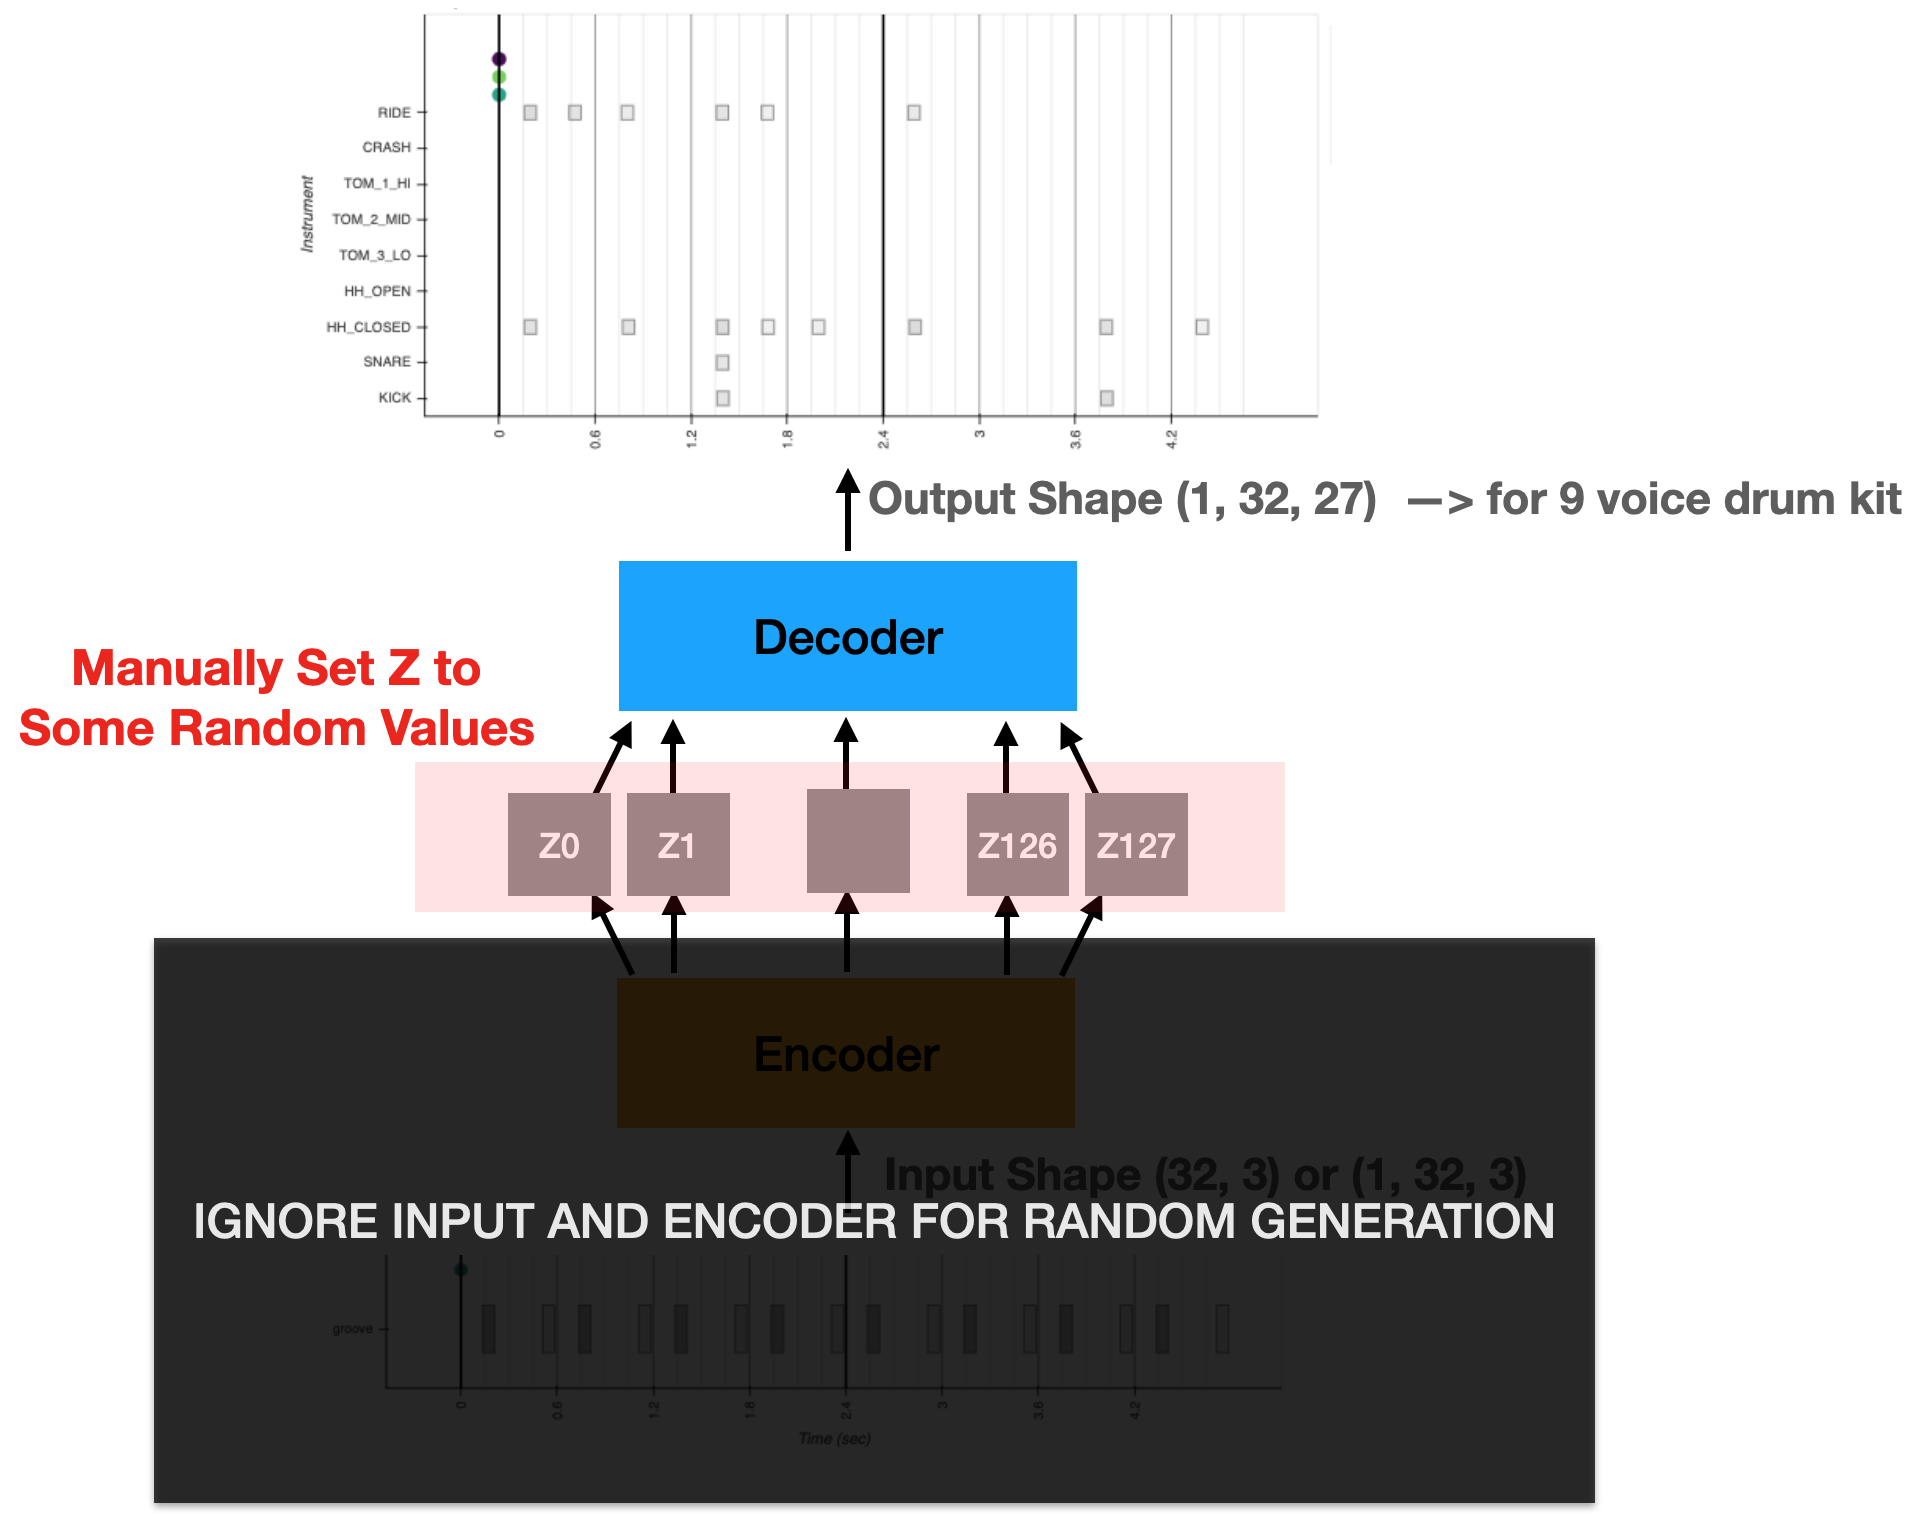


In [ ]:
latents = []
labels = []
metadatas = []
use_all_styles = True
empty_hvo_seqs = []
for gt_sample in test_set:
    if (use_all_styles or (gt_sample.metadata["style_primary"] in ["rock", "funk", "afrobeat"])):
        empty_hvo_seqs.append(gt_sample.copy_empty())
        metadatas.append(gt_sample.metadata)
        labels.append(gt_sample.metadata["style_primary"])
        groove = torch.tensor([gt_sample.flatten_voices(reduce_dim=True)], dtype=torch.float32)[:,:32, :]
        latent_z = encode_into_latent_z(model, fix_dimensions(groove))
        latents.append(latent_z.detach().cpu().numpy())

latents = np.array(latents).squeeze(1)
features = np.expand_dims(latents, -1) # we use each dimension of latent_z as a feature
feature_labels = [f"z_{dim}" for dim in range(features.shape[1])]

In [ ]:
data = {"style_primary": [style for style in labels]}
data.update({f"z_{dim_i}": latents[:, dim_i] for dim_i in range(features.shape[1])})
df = pd.DataFrame(data)
df.head()

style_primary       z_0       z_1       z_2       z_3       z_4       z_5  \
0          soul -1.154533 -0.782624 -0.219090 -1.033307  0.171655  0.468963   
1          soul -0.640432 -0.987081 -1.677624  0.226760  0.704142  0.027352   
2          soul  0.597497 -1.599465  0.117089  1.123156  0.457832  0.565699   
3          soul  1.209543 -0.809450  0.896081  0.895536 -1.176258  0.230307   
4          soul -1.089120 -0.869319  0.419601 -1.089868  0.068235 -0.115047   

        z_6       z_7       z_8  ...     z_118     z_119     z_120     z_121  \
0 -1.396466 -0.986321 -1.609021  ... -1.203421 -0.355270  0.319269  0.397730   
1 -0.152028  0.942788  0.607875  ... -1.128048 -0.918303 -0.277280  1.725728   
2 -0.789887 -0.648167 -0.516155  ... -0.945910 -0.676651  0.643550  1.139149   
3 -0.359798  0.618281 -0.910881  ...  0.564440  0.027790  1.126677  0.508217   
4  0.777715  1.770324 -0.272873  ...  0.645264 -0.028007  0.995194  0.492012   

      z_122     z_123     z_124     z_125     z_126     z_127  
0  1.780500 -0.039199 -0.501685 -0.669545  2.134080 -1.523093  
1 -0.603361  0.421633 -1.153742  0.811794  1.653981 -1.275579  
2 -1.318483  1.386926 -1.226320  0.909403  1.582978  0.623544  
3 -1.479269  1.030726  0.007798  0.801151  1.648880  1.872385  
4 -0.636636  0.189715 -1.031119  1.502583  1.524704  2.806068  

[5 rows x 129 columns]

In [ ]:
voice_thresholds=[0.3]*9


# random_z = [np.random.uniform(df[f"z_{i}"].min(), df[f"z_{i}"].max()) for i in range(len(latents[0, :]))]
# random_z = [np.random.normal(loc=df[f"z_{i}"].mean(), scale=df[f"z_{i}"].std()) for i in range(len(latents[0, :]))]
random_z = [np.random.normal(loc=df[f"z_{i}"].mean(), 
                             scale=df[f"z_{i}"].std()) for i in range(len(latents[0, :]))]


hvo = decode_z_into_drums(model, random_z, sampling_thresh=0.5)
                   
hvo_seq_ = empty_hvo_seqs[0]
hvo_seq_.hvo = hvo.detach().cpu().numpy()[0]

if (hvo_seq_.get_number_of_active_voices()>0):
    # draw and synthesize
    show(hvo_seq_.piano_roll())
    audio = hvo_seq_.synthesize(sf_path="hvo_sequence/soundfonts/TamaRockSTAR.sf2")

else:
    print("Empty Score")

ipd.Audio(audio, rate=44100, autoplay=False) # load a NumPy array

# 4. Interpolating between two patterns

In this part, we will assume that we have two grooves (groove_a and groove_b). We will use these grooves as the starting/ending point of a performance, and try to generate the middle sections by a linear equally-distanced interpolation in the latent space.

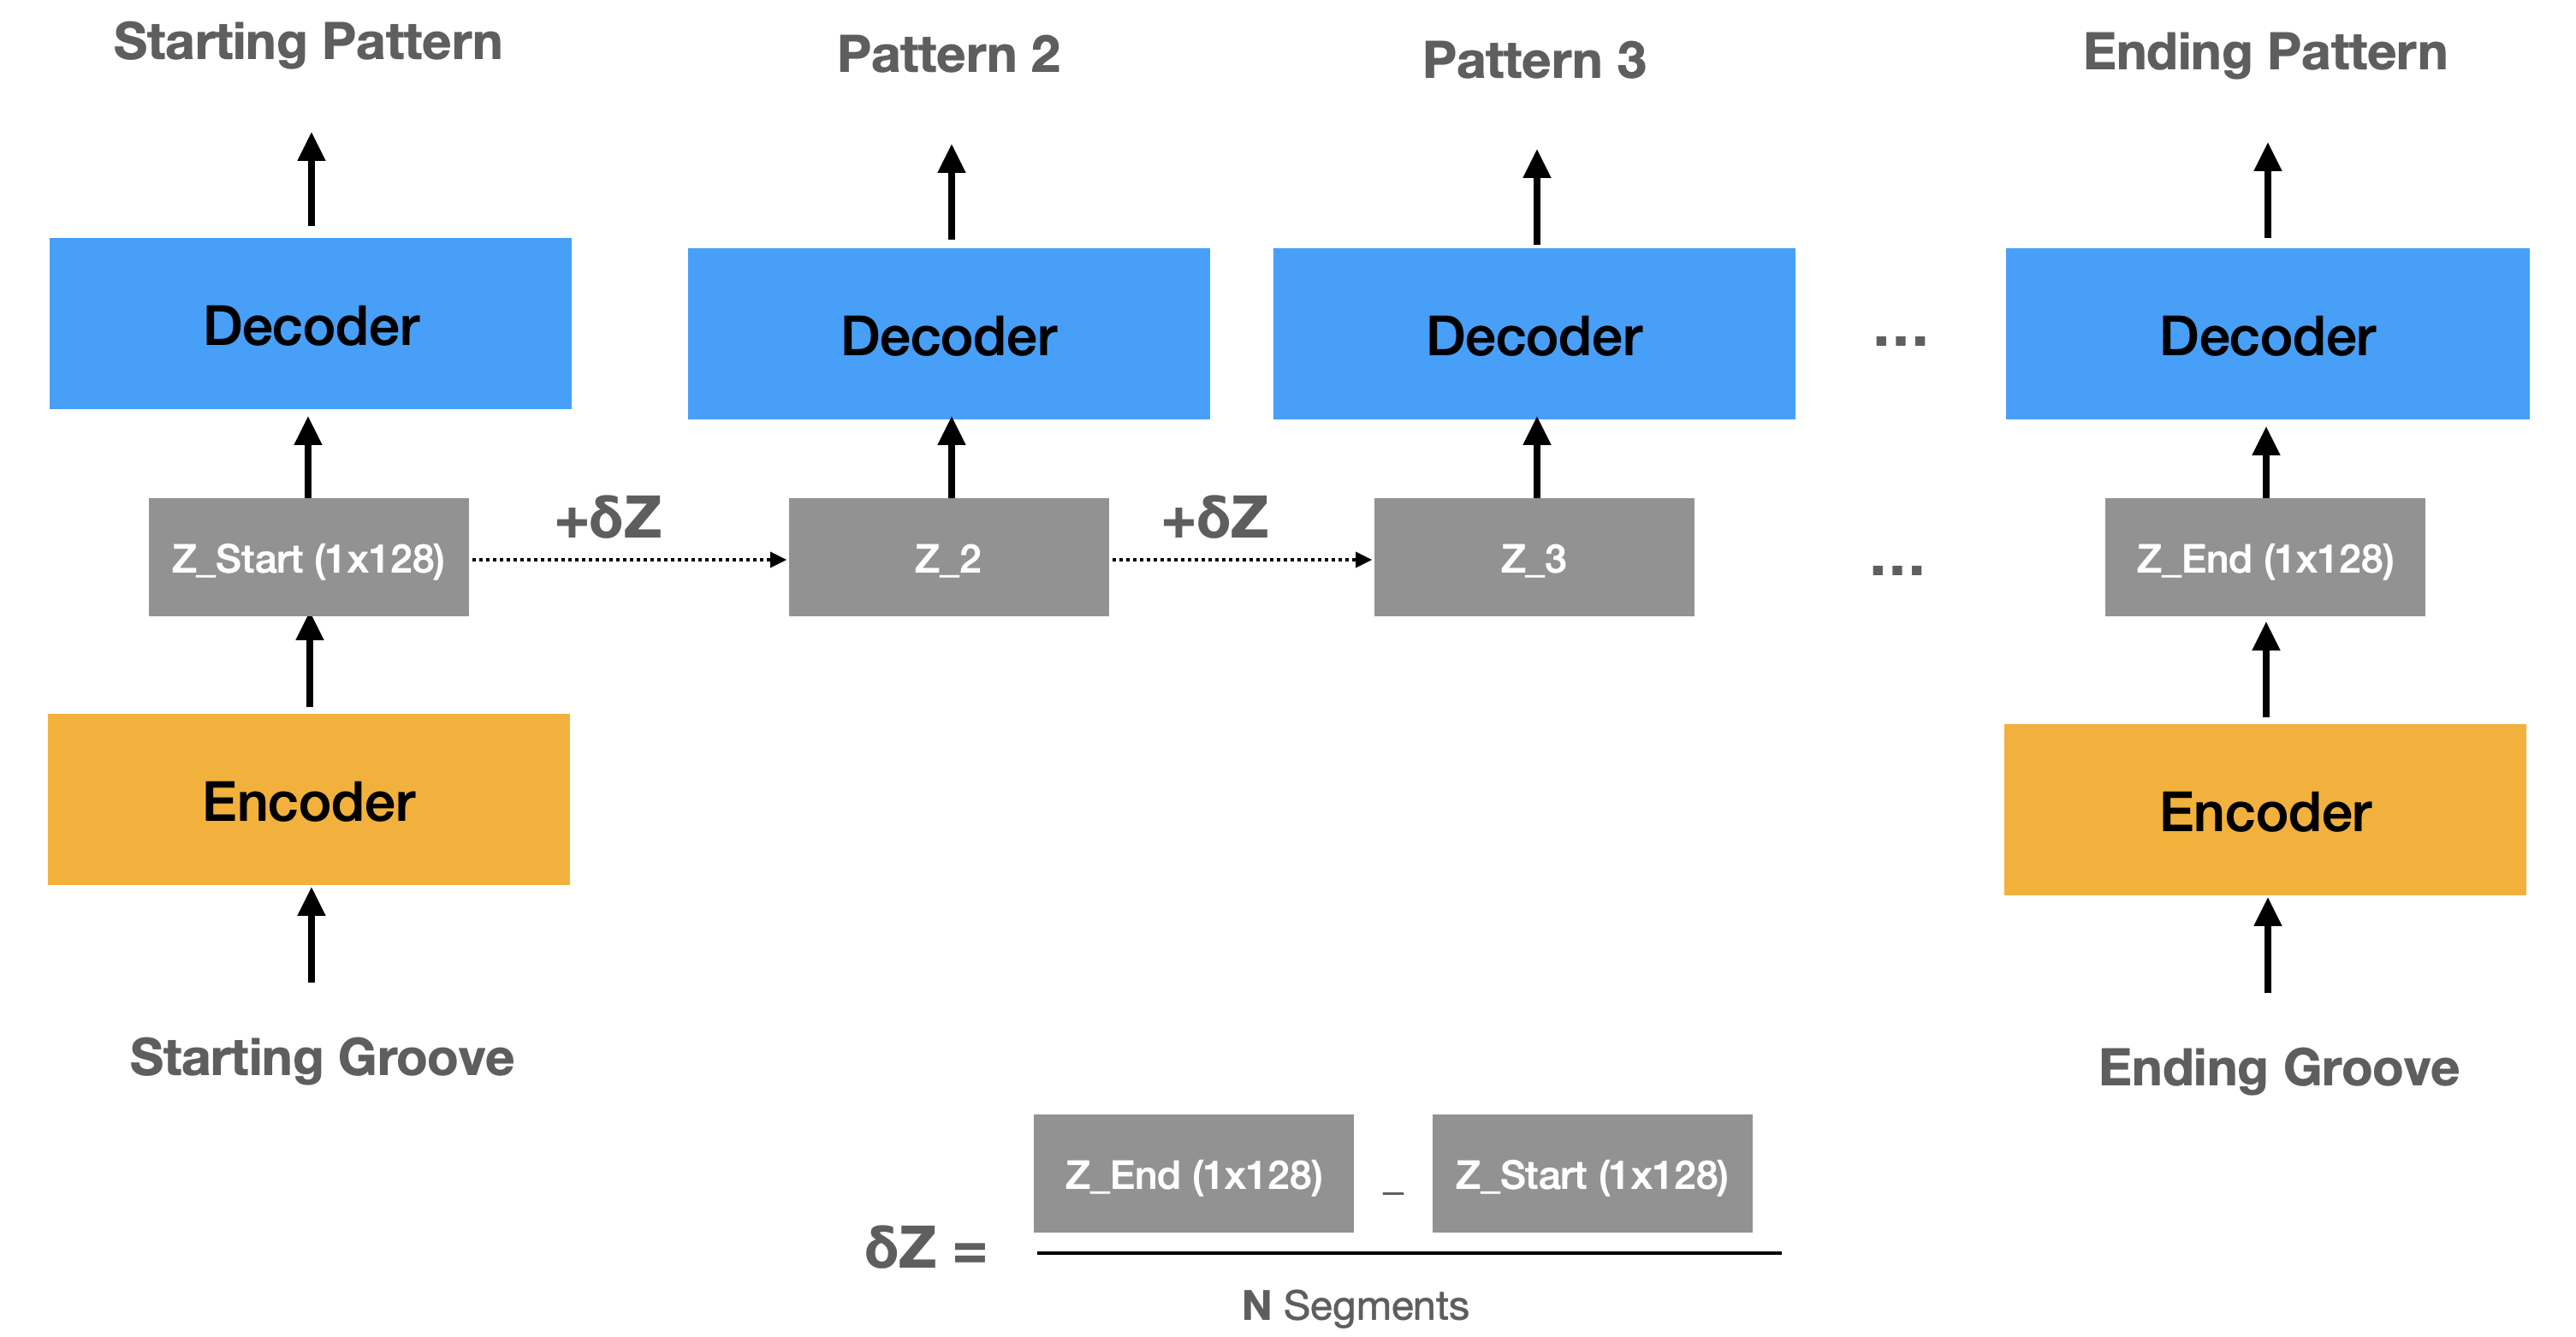

In [ ]:
# grab two sequences
# seq_a = test_set[98]
# seq_b = test_set[870]

seq_a = test_set[np.random.randint(len(test_set))]
seq_b = test_set[np.random.randint(len(test_set))]

groove_a = torch.tensor(seq_a.flatten_voices(reduce_dim=True), dtype=torch.float32)
groove_b = torch.tensor(seq_b.flatten_voices(reduce_dim=True), dtype=torch.float32)

z_a = encode_into_latent_z(model, fix_dimensions(groove_a))
z_b = encode_into_latent_z(model, fix_dimensions(groove_b))

# select the number of segments in between
num_steps_to_interpolate = 4


# 
delta = (z_b - z_a)/(num_steps_to_interpolate + 1.0)
latent_zs = [z_a]
for i in range(num_steps_to_interpolate):
  latent_zs.append(z_a + (i+1) * delta)
latent_zs.append(z_b)

# decode latents into drum patterns
sequences = []

for latent in latent_zs:
  temp = seq_a.copy_empty()
  temp.hvo = decode_z_into_drums(model, latent, 0.5).detach().cpu().numpy()[0]
  sequences.append(temp)

# append all scores 
temp = sequences[0].copy()
for seq in sequences[1:]:
  temp = temp + seq


audio = plot_and_synthesize(temp)
ipd.Audio(audio, rate=44100, autoplay=True) 

<ipython-input-85-b1d5cb9205ef>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return model_.sample(latent_z=torch.tensor(latent_z, dtype=torch.float32),


In [ ]:
save_to_midi(temp)

saved to 520c730a-d4c2-4368-a296-f1b870e4679b.mid
